This notebook contains a standalone example for using the Blahut-Arimoto algorithm to find the optimal prior in a Gaussian channel with peak power constraint. First using a standard implementation, and second, by initializing discrete peaks and iterating their positions and weights.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from blahut import blahut_update, weight_step, pos_step

Define x-axis and y-axis:

In [2]:
xvec = np.linspace(-1, 1, 500)
yvec = np.linspace(-0.5, 1.5, 500)

dx = xvec[1] - xvec[0]
dy = yvec[1] - yvec[0]

Example Gaussian channel with peak power constraint:

In [3]:
# noise
@njit
def sigma(xvec): 
    return 0.1
# mean
@njit
def mu(xvec):
    return 1/(1+np.exp(-xvec*5))

@njit(parallel=True)
def fill_p_y_given_x(xvec, yvec, mu, sigma):
    # Compute the conditional probability mass function p(y|x) for each x and y.
    p_y_given_x = np.zeros((len(yvec), len(xvec)))
    for i in prange(len(xvec)):
        x = xvec[i]
        mu_x = mu(x)
        sigma_x = sigma(x)
        for j in range(len(yvec)):
            y = yvec[j]
            p_y_given_x[j, i] = 1/(sigma_x*np.sqrt(2*np.pi)) * np.exp(-(y-mu_x)**2/(2*sigma_x**2))

    for i in prange(len(xvec)):
        col_sum = 0.0
        for j in range(len(yvec)):
            col_sum += p_y_given_x[j, i]
        for j in range(len(yvec)):
            p_y_given_x[j, i] /= col_sum
    return p_y_given_x

@njit(parallel=True)
def fill_d_pyx_dx(xvec, yvec, mu, sigma):
    # Compute the numerical derivatives of p(y|x) with respect to x using central differences.
    # Could also use a functional form of p(y|x) if you know it, which is cheaper. 
    d_pyx_dx = np.zeros((len(yvec), len(xvec)))
    for i in prange(len(xvec)):
        x = xvec[i]
        mu_x = mu(x)
        sigma_x = sigma(x)
        d_mu_dx = (mu(x+1e-5) - mu(x-1e-5)) / 2e-5
        d_sigma_dx = (sigma(x+1e-5) - sigma(x-1e-5)) / 2e-5
        for j in range(len(yvec)):
            y = yvec[j]
            p_y_given_x = 1/(sigma_x*np.sqrt(2*np.pi)) * np.exp(-(y-mu_x)**2/(2*sigma_x**2))
            d_pyx_dx[j, i] = p_y_given_x * ((y-mu_x)/sigma_x**2 * d_mu_dx + (y-mu_x)**2/sigma_x**3 * d_sigma_dx - 1/sigma_x * d_sigma_dx)

    return d_pyx_dx

In [4]:
p_y_given_x = fill_p_y_given_x(xvec, yvec, mu, sigma)

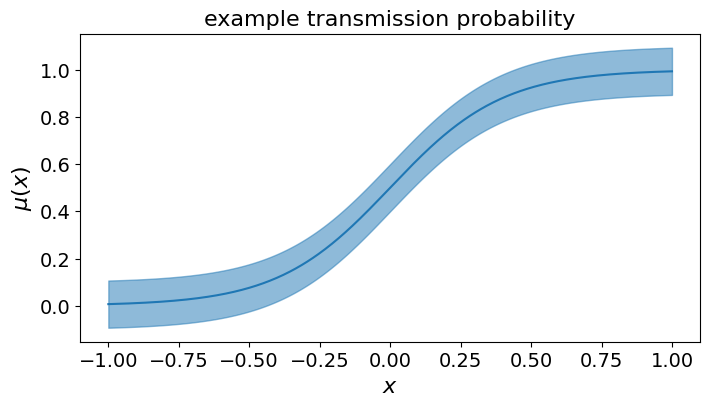

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(xvec, mu(xvec))
ax.fill_between(xvec, mu(xvec) - sigma(xvec), mu(xvec) + sigma(xvec), color='tab:blue', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$\mu(x)$', fontsize=16)
ax.set_title('example transmission probability', fontsize=16)
plt.show(fig)

Standard Blahut-Arimoto implementation:

In [74]:
p_x = np.ones(len(xvec)) / len(xvec)  # initialise uniform prior

Lower bound: 1.2091321977502412 bits
Upper bound: 1.2092321941744197 bits


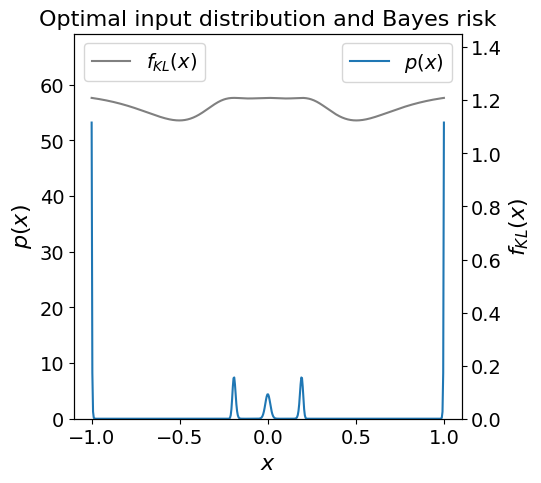

In [75]:
threshold = 1e-4
max_iterations = 10000

for _ in range(max_iterations):
    I_L, I_U, f_kl_new, p_x = blahut_update(p_x, p_y_given_x)
    if I_U - I_L < threshold:
        break

print(f"Lower bound: {I_L} bits")
print(f"Upper bound: {I_U} bits")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(xvec, p_x/dx)
ax.set_ylabel(r"$p(x)$", fontsize=16)
ax.set_xlabel(r"$x$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(-0.0001, 1.3*np.max(p_x/dx))

ax_secondary = ax.twinx()
ax_secondary.set_ylabel(r'$f_{KL}(x)$', fontsize=16)
ax_secondary.tick_params(axis='y', which='major', labelsize=14)
ax_secondary.plot(xvec, f_kl_new, color = 'gray')
ax_secondary.set_ylim(0, 1.2*np.max(f_kl_new))

ax.legend([r'$p(x)$', r'$f_{KL}(x)$'], fontsize=14)
ax_secondary.legend([r'$f_{KL}(x)$'], fontsize=14, loc='upper left')

ax.set_title('Optimal input distribution and Bayes risk', fontsize=16)

plt.show(fig)

Initialise discrete prior using $K$ atoms: 

In [89]:
K = 5
weights = 1/K*np.ones(K)
x_positions = np.linspace(-1, 1, K)

In [90]:
convergence_goal = 1e-5 # convergence goal for the weight optimization
max_iter = 10000 # maximum number of iterations for the weight optimization

Iterate weight updates and gradient descent of the positions. (Play around with the number of iterations to see it converge!)

Final atom positions: [-1.00000000e+00 -1.90369014e-01  1.15193505e-15  1.90369014e-01
  1.00000000e+00]
Final atom weights: [0.25240332 0.17002945 0.15513447 0.17002945 0.25240332]


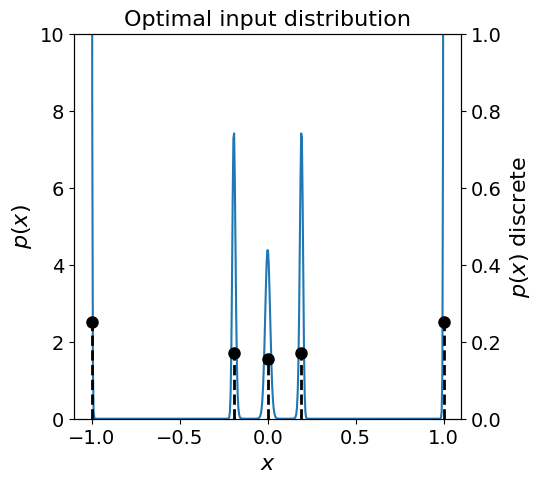

In [ ]:
for _ in range(1000):
    err, weights = weight_step(convergence_goal, max_iter, weights, fill_p_y_given_x(x_positions, yvec, mu, sigma))
    gradient = pos_step(yvec, weights, fill_p_y_given_x(x_positions, yvec, mu, sigma), fill_d_pyx_dx(x_positions, yvec, mu, sigma))
    x_positions += 0.01 * gradient
    x_positions = np.clip(x_positions, -1, 1)  # ensure x_positions stay within [-1, 1]

print("Final atom positions:", x_positions)
print("Final atom weights:", weights)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(xvec, p_x/dx)
ax.set_ylabel(r"$p(x)$", fontsize=16)
ax.set_xlabel(r"$x$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(-0.0001, 10)

ax_secondary = ax.twinx()
ax_secondary.set_ylabel(r'$p(x)$ discrete', fontsize=16)
ax_secondary.tick_params(axis='y', which='major', labelsize=14)

ax_secondary.vlines(x_positions, 0, weights, colors='k', linestyles='dashed', linewidth=2)
ax_secondary.plot(x_positions, weights, marker='o', label=r'$p_{\star}^{(1)}(t)$', markersize=8, linewidth=0, color = 'k')

ax_secondary.set_ylim(0, 1)
ax.set_title('Optimal input distribution', fontsize=16)


plt.show(fig)

If you use too few atoms, you will see that lower bounds I_L and I_U have not converged: the atoms will also not be located at maxima of the Bayes risk. 

If you use too many atoms, the algorithm pushes one or more atoms to zero weight. 